In [ ]:
# подключаем личный диск к блокноту
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os 
# назначем корневые пути до исходных данных
path="/content/drive/MyDrive/source/DICOM"
inPath=os.listdir("/content/drive/MyDrive/source/DICOM")
inPath

['Tuberculosis', 'Pneumonia', 'Cancer']

In [ ]:
pneum_path=path+"/Pneumonia/Пневмония"
tub_path=path+"/Tuberculosis/Туберкулез"
can_path=path+"/Cancer/0"
print(pneum_path,
tub_path,
can_path)

/content/drive/MyDrive/source/DICOM/Pneumonia/Пневмония /content/drive/MyDrive/source/DICOM/Tuberculosis/Туберкулез /content/drive/MyDrive/source/DICOM/Cancer/0


In [ ]:
arrPneumPath=os.listdir(pneum_path)
arrTubPath=os.listdir(tub_path)
arrCanPath=os.listdir(can_path)

In [ ]:
# функция вычисления путей до конктреного слоя кт
def addPath(path, arrPath):
    arr=[]
    for i in range(0, len(arrPath)):
        inDirectory=os.listdir(path+"/"+arrPath[i])
        new_path=path+"/"+arrPath[i]
        for j in range(0, len(inDirectory)):
            inPostDirectory=os.listdir(new_path+"/"+inDirectory[j]+"/")
            for k in range(0, len(inPostDirectory)):
                end_pneum_path=new_path+"/"+inDirectory[j]+"/"+inPostDirectory[k]
                inLastDir=os.listdir(end_pneum_path)
                for m in range(0, len(inLastDir)):
                    endDir=end_pneum_path+"/"+inLastDir[m]
                    arr.append(endDir)
    return arr
arrPneum=addPath(pneum_path, arrPneumPath)
arrTub=addPath(tub_path, arrTubPath)
arrCan=addPath(can_path, arrCanPath)

In [ ]:
print("lenPneum: ", len(arrPneum), "\nlenTub: ", len(arrTub), "\nlenCan: ", len(arrCan))

lenPneum:  2100 
lenTub:  2515 
lenCan:  1558


In [ ]:
!pip install pydicom
!pip install opencv-python
!pip install Pillow
!pip install numpy scipy scikit-learn

     |████████████████████████████████| 2.0 MB 5.5 MB/s 


In [ ]:
# импортируем необходимые библиотеки
import pydicom as dicom
import cv2
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import numpy as np


In [ ]:
size=[]
# функция вычисления количества больных каждого типа болезни
def sizeCheked(arrPneum):
    pixel_array_numpy=[]
    for i in range(0, len(arrPneum)):
        try:
            image_path = arrPneum[i]
            ds = dicom.dcmread(image_path)
            pixel_array_numpy.append(ds.pixel_array)
        except FileNotFoundError:
            print(i, ": none")
    for i in range(0, len(pixel_array_numpy)):
        for j in range(0, len(pixel_array_numpy[i])):
            if(pixel_array_numpy[i][j].size!=512):
                print(pixel_array_numpy[i][j].size)

In [ ]:
# функция форматирование путей для pandas
def spliting(arr):
    splitArray=[]
    for i in range(0,len(arr)):
        splitArray.append(arr[i].split('/'))
    return splitArray
spliter=spliting(arrPneum)+spliting(arrTub)+spliting(arrCan)

In [ ]:
# созздаепм верный формат путей до КТ снимков для загрузки их в pandas
preCsv=[]
for i in range(0,len(spliter)):
    preCsv.append([spliter[i][6], spliter[i][10], "/".join(spliter[i])])

In [ ]:
!pip install pandas

In [ ]:
import pandas as pd
df = pd.DataFrame(preCsv) # загружаем данные КТ снимоков в pandas
df.to_csv('file.csv', index=False, header=True) # сохраняем в файл

In [ ]:
# назначем названия колонок и раскрываем содержимое датафрейма:
df.columns = ['Type', 'img_name', 'path_to_img']
df

,Type,img_name,path_to_img
0,Pneumonia,1.2.392.200036.9116.2.5.1.16.1613468577.126923...,/content/drive/MyDrive/source/DICOM/Pneumonia/...
1,Pneumonia,1.2.392.200036.9116.2.5.1.16.1613468577.126923...,/content/drive/MyDrive/source/DICOM/Pneumonia/...
2,Pneumonia,1.2.392.200036.9116.2.5.1.16.1613468577.126923...,/content/drive/MyDrive/source/DICOM/Pneumonia/...
3,Pneumonia,1.2.392.200036.9116.2.5.1.16.1613468577.126923...,/content/drive/MyDrive/source/DICOM/Pneumonia/...
4,Pneumonia,1.2.392.200036.9116.2.5.1.16.1613468577.126923...,/content/drive/MyDrive/source/DICOM/Pneumonia/...
...,...,...,...
6168,Cancer,1.2.392.200036.9116.2.5.1.48.1211466065.150758...,/content/drive/MyDrive/source/DICOM/Cancer/0/L...
6169,Cancer,1.2.392.200036.9116.2.5.1.48.1211466065.150758...,/content/drive/MyDrive/source/DICOM/Cancer/0/L...
6170,Cancer,1.2.392.200036.9116.2.5.1.48.1211466065.150758...,/content/drive/MyDrive/source/DICOM/Cancer/0/L...
6171,Cancer,1.2.392.200036.9116.2.5.1.48.1211466065.150758...,/content/drive/MyDrive/source/DICOM/Cancer/0/L...


In [ ]:
import numpy as np
# функция преобразования в хаумсфилдские юниты снимка КТ
def get_pixels_hu(scans):
    image = np.stack([scans.pixel_array])#np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # возможно, так как значения всегда должны быть достаточно низкими (<32k)
    image = image.astype(np.int16)

    # Установит значение пикселов вне области сканирования равным 1
    # intercept обычно составляет -1024, так что воздух составляет примерно 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans.RescaleIntercept
    slope = scans.RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [ ]:
from skimage.transform import resize

In [ ]:
# Обертачная функция для финкции преобразования в хаумсфилдские юниты снимка КТ
def get_pixel_uid(x):
    try:
        dcm_x=dicom.dcmread(x, force=True)
        #dcm_x.file_meta.TransferSyntaxUID = dicom.uid.ImplicitVRLittleEndian
    
        return get_pixels_hu(dcm_x).flatten()
    except AttributeError:
        return None

In [ ]:
import tensorflow as tf

In [ ]:
# преорбразуем каждый DICOM снимок в хаумсфилдские юниты
with tf.device('/GPU:0'):
        df["img"]=df["path_to_img"].apply(lambda x: get_pixel_uid(x))

In [ ]:
#Standardize the pixel values
from sklearn.cluster import KMeans
from skimage import morphology
from skimage import measure


def make_lungmask(img, display=False):
    row_size= img.shape[0]
    col_size = img.shape[1]
    
    mean = np.mean(img)
    std = np.std(img)
    
    img = img-mean
    img = img/std
    # Найти среднее значение пикселя рядом с легкими
    # для перенормировки размытых изображений
    middle = img[int(col_size/5):int(col_size/5*4),int(row_size/5):int(row_size/5*4)] 
    mean = np.mean(middle)  
    max = np.max(img)
    min = np.min(img)
    # 
    # 
    img[img==max]=mean
    img[img==min]=mean
    #
    # Использование Kmeans для разделения переднего плана (мягкие ткани / кости) и фона (легкие / воздух)
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    #Получаю центр каждого кластера
    centers = sorted(kmeans.cluster_centers_.flatten())
    
    threshold = np.mean(centers)
    
    thresh_img = np.where(img<threshold,1.0,0.0)  # пороговое значение изображения

    # Сначала удаляются более мелкие элементы, затем расширяются, чтобы включить некоторые пиксели, окружающие легкое. 
    # нельзя случайно задеть легкое.

    eroded = morphology.erosion(thresh_img,np.ones([3,3]))
    dilation = morphology.dilation(eroded,np.ones([8,8]))
    #Получение связанной области изображения
    labels = measure.label(dilation) # Разные части отображаются разными цветами
    
    #Получение уникальных областей
    label_vals = np.unique(labels)
    
    regions = measure.regionprops(labels)
   
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    mask = np.ndarray([row_size,col_size],dtype=np.int8)
    mask[:] = 0

    #
    #  После того, как останутся только легкие, делаем еще одну операцию, чтобы заполнить и удалить легочную маску
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    print("mask: ",mask)
    mask = morphology.dilation(mask,np.ones([10,10])) # one last dilation

    # if (display):
    #     fig, ax = plt.subplots(3, 2, figsize=[12, 12])
    #     ax[0, 0].set_title("Original")
    #     ax[0, 0].imshow(img, cmap='gray')
    #     ax[0, 0].axis('off')
    #     ax[0, 1].set_title("Threshold")
    #     ax[0, 1].imshow(thresh_img, cmap='gray')
    #     ax[0, 1].axis('off')
    #     ax[1, 0].set_title("After Erosion and Dilation")
    #     ax[1, 0].imshow(dilation, cmap='gray')
    #     ax[1, 0].axis('off')
    #     ax[1, 1].set_title("Color Labels")
    #     ax[1, 1].imshow(labels, cmap='plasma')
    #     ax[1, 1].axis('off')
    #     ax[2, 0].set_title("Final Mask")
    #     ax[2, 0].imshow(mask, cmap='gray')
    #     ax[2, 0].axis('off')
    #     ax[2, 1].set_title("Apply Mask on Original")
    #     ax[2, 1].imshow(mask*img, cmap='gray')
    #     ax[2, 1].axis('off')
        
    #     plt.show()
    return mask*img
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing


In [ ]:
df.columns = ['Type', 'img_name', 'path_to_img']

In [ ]:
# функция дублирования одного слоя на 3
def expand_greyscale_image_channels(grey_pil_image):
    grey_image_arr = np.array(grey_pil_image)
    grey_image_arr = np.expand_dims(grey_image_arr, -1)
    grey_image_arr_3_channel = grey_image_arr.repeat(3, axis=-1)
    return grey_image_arr_3_channel

In [ ]:
import matplotlib.pylab as plt

In [ ]:
# функция получения необходимого преобразованнго слоя
def aply_mask(img):
    try:
         # применение алгоритма сегментации и прменения алгоритма бикубической интрполяции для изменения размера каждого слоя 
        return  expand_greyscale_image_channels(resize(make_lungmask(img.reshape(512,512)), (64,64)))
    except:
        return None

In [ ]:
# преобразование данных
df["mask"]=df["img"].apply(lambda x:aply_mask(x))

In [ ]:
# избавление от дубликатов
dx = df.sample(frac=1).reset_index(drop=True)

In [ ]:
dx.isnull().sum()

Type           0
img_name       0
path_to_img    0
img            0
mask           0
dtype: int64

In [ ]:
dx=dx[dx['img'].notna()]
dx.isnull().sum()

Type           0
img_name       0
path_to_img    0
img            0
mask           0
dtype: int64

In [ ]:
# удаление не нужных столбцов
del dx['img']
del dx['path_to_img']
del dx['img_name']

In [ ]:
print(dx)

              Type                                               mask
0     Tuberculosis  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
1     Tuberculosis  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
2     Tuberculosis  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
3     Tuberculosis  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
4     Tuberculosis  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
...            ...                                                ...
6168     Pneumonia  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
6169        Cancer  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
6170  Tuberculosis  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
6171        Cancer  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...
6172  Tuberculosis  [[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0,...

[6173 rows x 2 columns]


In [ ]:
Xc = dx['mask'] # преобразованные изображения
Yc = dx['Type'] # болезнь пациента
# создаем обЪект с мультиклассовыми метками
encoder = LabelEncoder()
encoder.fit(Yc)


LabelEncoder()

In [ ]:
# пропускаем изображение исколючение
Xc=np.concatenate((Xc[0:107],Xc[108:len(Xc)]))  
Yc=np.concatenate((Yc[0:107],Yc[108:len(Yc)])) 

In [ ]:
# преобразуем стобец с болезнью в мультукласовый
encoded_Yc = encoder.transform(Yc)
dummy_y = np_utils.to_categorical(encoded_Yc)

In [ ]:
#преобразование Python List в numpyNdArray
new_X=[]
for i in range(0,len(Xc)):
    new_X.append(Xc[i])
new_X=np.array(new_X)
new_X.shape

**RESNET**

In [ ]:
# импортируем все необходимые библиотеки
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
from urllib.request import urlopen,urlretrieve
from PIL import Image
from tqdm import tqdm_notebook
%matplotlib inline
from sklearn.utils import shuffle
import cv2
from keras.models import load_model
from sklearn.datasets import load_files   
from keras.utils import np_utils
from glob import glob
from keras import applications
from keras.preprocessing.image import ImageDataGenerator 
from keras import optimizers
from keras.models import Sequential,Model,load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50 # импортируем готовую модель ResNet50

In [ ]:
img_height,img_width = 64,64 # размер одного изображения
num_classes = 3 # количество классов
#создаем модель исключаем первый уровень свертки  и с размером изображении 64 на 64
base_model = ResNet50(weights= None, include_top=False, input_shape= (img_height,img_width,3))

In [ ]:
# создаем полносвязанную сеть для классификатора
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

In [ ]:
from tensorflow.keras.optimizers import SGD, Adam
#добавлеем оптимизаторы и функцию потерь
adam = Adam(lr=0.0001)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#создаем конфигурацию хода обучения сети
IMAGE_SIZE = [64, 64] 
BATCH_SIZE = 50
EPOCHS = 100


In [ ]:
# обучаем модель
history = model.fit(new_X[0:4000], dummy_y[0:4000], batch_size=BATCH_SIZE,validation_data=(new_X[4000:5934], dummy_y[4000:5934]), epochs=EPOCHS)


Epoch 1/100
80/80 [==============================] - 24s 102ms/step - loss: 1.9174 - accuracy: 0.3980 - val_loss: 1.0818 - val_accuracy: 0.4023
Epoch 2/100
80/80 [==============================] - 6s 80ms/step - loss: 1.4011 - accuracy: 0.4832 - val_loss: 1.0794 - val_accuracy: 0.4018
Epoch 3/100
80/80 [==============================] - 7s 86ms/step - loss: 1.1402 - accuracy: 0.5570 - val_loss: 1.1249 - val_accuracy: 0.3578
Epoch 4/100
80/80 [==============================] - 6s 81ms/step - loss: 0.8996 - accuracy: 0.6610 - val_loss: 1.1618 - val_accuracy: 0.3557
Epoch 5/100
80/80 [==============================] - 6s 81ms/step - loss: 0.7000 - accuracy: 0.7563 - val_loss: 1.1418 - val_accuracy: 0.3961
Epoch 6/100
80/80 [==============================] - 7s 81ms/step - loss: 0.5300 - accuracy: 0.7993 - val_loss: 1.4667 - val_accuracy: 0.3697
Epoch 7/100
80/80 [==============================] - 7s 88ms/step - loss: 0.5020 - accuracy: 0.8130 - val_loss: 1.4879 - val_accuracy: 0.4255
Epoc

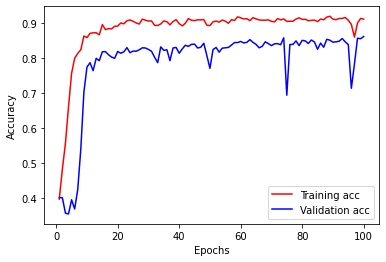

In [ ]:
#выводим график хода обучения
import matplotlib.pyplot as plt
history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# вычисляем f1 метрику для тестовой выборки
from sklearn.metrics import f1_score
pred = model.predict(new_X[4000:5934])
trues = dummy_y[4000:5934]
f1_score(np.argmax(trues, axis=1), np.argmax(pred, axis=1), average=None)

array([0.88743169, 0.84485007, 0.86116984])

**VGG16**

In [ ]:
# Конфигурируем процесс обучения нейросети 
IMAGE_SIZE = [64, 64] 
BATCH_SIZE = 50
EPOCHS = 200

In [ ]:
# импортируем все необходимые библиотеки
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16 # импортируем VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
num_classes = 3 # количество классов
vgg = VGG16(input_shape = IMAGE_SIZE + [3], weights = 'imagenet', include_top = False)  # input_shape = (64,64,3) as required by VGG

# создаем генерацию чекпоинтов на каждую эпоху
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# создаем полносвязанную сеть для классификатора
x = Flatten()(vgg.output)
x = Dense(num_classes, activation = 'softmax')(x)  
model = Model(inputs = vgg.input, outputs = x)
#добавлеем оптимизаторыы и функцию потерь
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
# Обучаем модель
history = model.fit(new_X[0:4500], dummy_y[0:4500], batch_size=BATCH_SIZE,validation_data=(new_X[4500:5400], dummy_y[4500:5400]), epochs=EPOCHS,callbacks=[cp_callback])


Epoch 1/200
90/90 [==============================] - ETA: 0s - loss: 0.1994 - accuracy: 0.9004
Epoch 1: saving model to training_1/cp.ckpt
90/90 [==============================] - 7s 82ms/step - loss: 0.1994 - accuracy: 0.9004 - val_loss: 0.4863 - val_accuracy: 0.8222
Epoch 2/200
90/90 [==============================] - ETA: 0s - loss: 0.2113 - accuracy: 0.8958
Epoch 2: saving model to training_1/cp.ckpt
90/90 [==============================] - 7s 81ms/step - loss: 0.2113 - accuracy: 0.8958 - val_loss: 0.4753 - val_accuracy: 0.8600
Epoch 3/200
90/90 [==============================] - ETA: 0s - loss: 0.2045 - accuracy: 0.8962
Epoch 3: saving model to training_1/cp.ckpt
90/90 [==============================] - 8s 84ms/step - loss: 0.2045 - accuracy: 0.8962 - val_loss: 0.4213 - val_accuracy: 0.8522
Epoch 4/200
90/90 [==============================] - ETA: 0s - loss: 0.1953 - accuracy: 0.8987
Epoch 4: saving model to training_1/cp.ckpt
90/90 [==============================] - 8s 84ms/step 

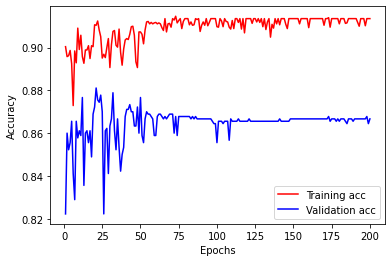

In [ ]:
# Создаем график процесса обучения
import matplotlib.pyplot as plt
history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)
plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# вычисляем f1 метрику для тестовой выборки
from sklearn.metrics import f1_score
pred = model.predict(new_X[5400:5934])
trues = dummy_y[5400:5934]
print('f1 score for test sample')
f1_score(np.argmax(trues, axis=1), np.argmax(pred, axis=1), average=None)

f1 score for test sample


array([0.86153846, 0.80995475, 0.85382831])

**Использование предобученнорй сети**

In [ ]:
# model.save('/contentmy_model.h5')


In [ ]:
# загуржаем готовую сеть
new_model = tf.keras.models.load_model('my_model.h5')


In [ ]:
#f1 метрика на тестовой выборке
from sklearn.metrics import f1_score
pred = new_model.predict(new_X[4500:5934])
trues = dummy_y[4500:5934]
f1_score(np.argmax(trues, axis=1), np.argmax(pred, axis=1), average=None)

array([0.88709677, 0.82632541, 0.86655113])

In [ ]:
#accuracy метрика на обучающей выборке
loss, acc = new_model.evaluate(new_X[0:4500], dummy_y[0:4500], verbose=2)
print("Restored model, learning accuracy: {:5.2f}%".format(100 * acc))


141/141 - 2s - loss: 0.1552 - accuracy: 0.9136 - 2s/epoch - 17ms/step
Restored model, learning accuracy: 91.36%


In [ ]:
#accuracy метрика на тестовой выборке
loss, acc = new_model.evaluate(new_X[5400:5934], dummy_y[5400:5934], verbose=2)
print("Restored model, test accuracy: {:5.2f}%".format(100 * acc))


17/17 - 1s - loss: 2.0152 - accuracy: 0.8371 - 746ms/epoch - 44ms/step
Restored model, test accuracy: 83.71%


In [ ]:
#f1 метрика на валидационной выборке
loss, acc = new_model.evaluate(new_X[4500:5934], dummy_y[4500:5934], verbose=2)
print("Restored model, validation accuracy: {:5.2f}%".format(100 * acc))

45/45 - 1s - loss: 1.8091 - accuracy: 0.8556 - 801ms/epoch - 18ms/step
Restored model, validation accuracy: 85.56%
